Episode 0 : -200423.33725852802
Episode 1 : -190419.08585385454
Episode 2 : -150593.35869135667
Episode 3 : -160560.08255996794
Episode 4 : -190486.9513151927
Episode 5 : -220442.63309665295
Episode 6 : -170470.54377331134
Episode 7 : -200432.40427781572
Episode 8 : -190501.9989625248
Episode 9 : -160553.33172685964
Episode 10 : -210454.7155974704
Episode 11 : -160545.62158495846
Episode 12 : -190429.34643398557
Episode 13 : -200539.52453229218
Episode 14 : -170499.32295472524
Episode 15 : -230393.12434917167
Episode 16 : -210492.07968337467
Episode 17 : -170477.39207571888
Episode 18 : -160563.94055629626
Episode 19 : -190512.2298288009
Episode 20 : -170455.81990666618
Episode 21 : -160578.33415864618
Episode 22 : -170518.49143596058
Episode 23 : -190518.8942242386
Episode 24 : -180508.203529251
Episode 25 : -210451.73950146342
Episode 26 : -190472.2619044144
Episode 27 : -180462.25655996022
Episode 28 : -150500.7257875587
Episode 29 : -190483.954743122
Episode 30 : -190411.9422781148

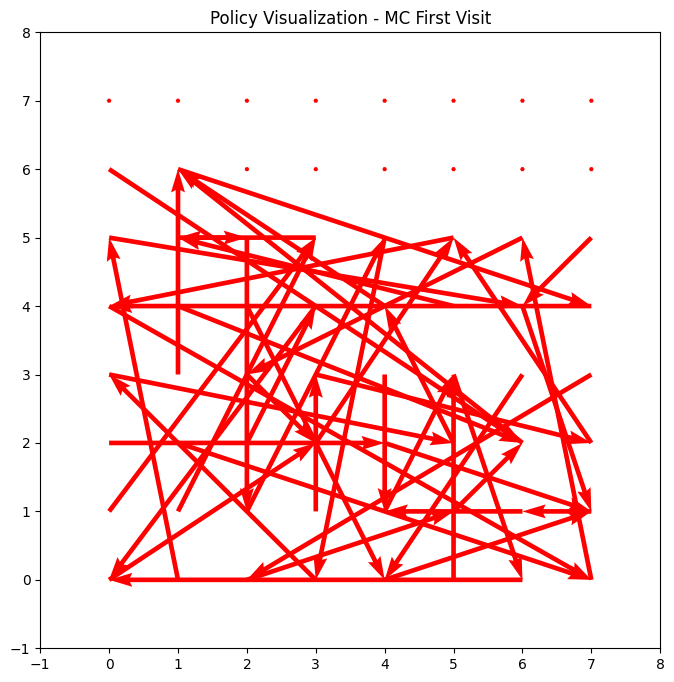

Optimal Policy (MC Every Visit):  [ 6  9 35 11 36 30  7 48 34 24 20 43 40 26 18 36 29 20 31 23 39 11 23  7
 21 13 21  7  7 42 46 17 20  0 49 10 40 49 16 27 18 38 18 44 11 14  1 10
 34  2]


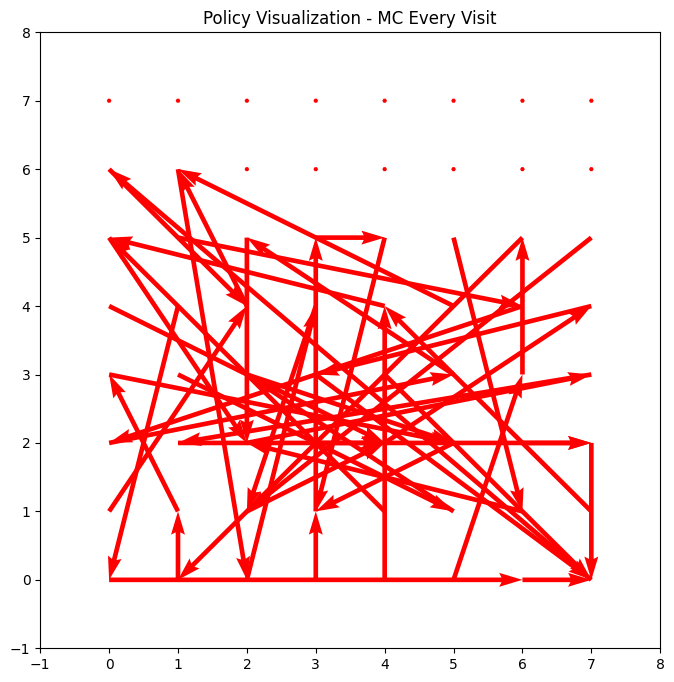

In [4]:
from typing import Dict, List, Optional, Tuple
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

class TSP(gym.Env):
    """Traveling Salesman Problem (TSP) RL environment for persistent monitoring."""

    def __init__(self, num_targets: int, max_area: int = 30, seed: int = None) -> None:
        """
        Initialize the TSP environment.

        Args:
            num_targets (int): Number of targets the agent needs to visit.
            max_area (int): Max area for targets (size of the 2D grid).
            seed (int, optional): Random seed for reproducibility.
        """
        super().__init__()
        if seed is not None:
            np.random.seed(seed=seed)

        self.steps: int = 0  # Step counter
        self.num_targets: int = num_targets  # Number of targets
        self.max_steps: int = num_targets  # Max steps to visit all targets
        self.max_area: int = max_area  # Max area for the grid

        # Generate random target locations and distances between them
        self.locations: np.ndarray = self._generate_points(self.num_targets)
        self.distances: np.ndarray = self._calculate_distances(self.locations)

        # Define observation space (current location and distances) and action space
        self.obs_low = np.concatenate([np.array([0], dtype=np.float32), np.zeros(self.num_targets, dtype=np.float32), np.zeros(2 * self.num_targets, dtype=np.float32)])
        self.obs_high = np.concatenate([np.array([self.num_targets], dtype=np.float32), 2 * self.max_area * np.ones(self.num_targets, dtype=np.float32), self.max_area * np.ones(2 * self.num_targets, dtype=np.float32)])
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[np.ndarray, Dict[str, None]]:
        """
        Reset the environment to the initial state (start from location 0).
        """
        self.steps: int = 0
        self.loc: int = 0  # Start location
        self.visited_targets: List = []  # List of visited targets
        self.dist: List = self.distances[self.loc]  # Distances from the current location
        state = np.concatenate([np.array([self.loc]), np.array(self.dist), np.array(self.locations).reshape(-1)], dtype=np.float32)
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """
        Take an action (move to the next target).
        
        Args:
            action (int): The index of the next target to move to.
        """
        self.steps += 1
        past_loc = self.loc  # Previous location
        next_loc = action  # Action specifies the next target to visit
        reward = self._get_rewards(past_loc, next_loc)  # Calculate reward based on the distance
        self.visited_targets.append(next_loc)  # Mark the next target as visited
        next_dist = self.distances[next_loc]  # Update distances from the new location
        terminated = bool(self.steps == self.max_steps)  # Termination if max steps are reached
        truncated = False
        next_state = np.concatenate([np.array([next_loc]), next_dist, np.array(self.locations).reshape(-1)], dtype=np.float32)
        self.loc, self.dist = next_loc, next_dist  # Update current location and distances
        return next_state, reward, terminated, truncated, {}

    def _generate_points(self, num_points: int) -> np.ndarray:
        """Generate random 2D points representing target locations."""
        points = []
        while len(points) < num_points:
            x = np.random.random() * self.max_area
            y = np.random.random() * self.max_area
            if [x, y] not in points:
                points.append([x, y])
        return np.array(points)

    def _calculate_distances(self, locations: List) -> float:
        """Calculate the distance matrix between all target locations."""
        n = len(locations)
        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])  # Euclidean distance
        return distances

    def _get_rewards(self, past_loc: int, next_loc: int) -> float:
        """Calculate reward based on distance. Penalize revisiting targets."""
        if next_loc not in self.visited_targets:
            reward = -self.distances[past_loc][next_loc]
        else:
            reward = -10000  # High penalty for revisiting targets
        return reward

    # Monte Carlo - Exploring Starts with First-Visit and Every-Visit
    def monte_carlo(self, num_episodes=10000, gamma=0.99, first_visit=True):
        """
        Perform Monte Carlo with exploring starts to find the optimal policy.

        Args:
            num_episodes (int): Number of episodes for simulation.
            gamma (float): Discount factor.
            first_visit (bool): Whether to use first-visit or every-visit MC.

        Returns:
            Q (np.ndarray): Optimal action-value function for each state-action pair.
            policy (np.ndarray): Optimal policy for each state.
        """
        Q = np.zeros((self.num_targets, self.num_targets))  # Initialize action-value function
        returns_count = np.zeros((self.num_targets, self.num_targets))  # Counts for averaging returns

        for _ in range(num_episodes):
            state, _ = self.reset()  # Reset environment to get initial state
            episode = []  # Store the episode (state, action, reward)

            for _ in range(self.max_steps):
                action = np.random.randint(self.num_targets)  # Random action
                next_state, reward, terminated, truncated, _ = self.step(action)
                episode.append((int(state[0]), action, reward))  # Store state as int for indexing
                state = next_state
                if terminated or truncated:
                    break

            G = 0  # Return (cumulative discounted reward)
            visited = set()  # Track visited state-action pairs
            for state, action, reward in reversed(episode):
                G = reward + gamma * G  # Calculate return
                if first_visit:
                    if (state, action) not in visited:
                        returns_count[state, action] += 1
                        Q[state, action] += (G - Q[state, action]) / returns_count[state, action]
                        visited.add((state, action))
                else:
                    returns_count[state, action] += 1
                    Q[state, action] += (G - Q[state, action]) / returns_count[state, action]

        policy = np.argmax(Q, axis=1)  # Derive policy from Q-values
        return Q, policy

    # Visualization for Policy
    def visualize_policy(self, policy, title="Policy Visualization"):
        """
        Visualize the policy using a quiver plot (arrows showing the next action from each location).

        Args:
            policy (np.ndarray): Policy to visualize.
            title (str): Title for the plot.
        """
        grid_size = int(np.ceil(np.sqrt(self.num_targets)))
        X, Y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))

        U = np.zeros_like(X, dtype=float)  # Horizontal movements
        V = np.zeros_like(Y, dtype=float)  # Vertical movements

        for i in range(self.num_targets):
            row, col = divmod(i, grid_size)
            next_target = policy[i]
            next_row, next_col = divmod(next_target, grid_size)
            U[row, col] = next_col - col
            V[row, col] = next_row - row

        plt.figure(figsize=(8, 8))
        plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, color='r')
        plt.xlim(-1, grid_size)
        plt.ylim(-1, grid_size)
        plt.title(title)
        plt.show()


if __name__ == "__main__":
    num_targets = 50  # Number of targets for TSP
    env = TSP(num_targets)

    # Run random episodes for testing
    obs = env.reset()
    ep_rets = []

    for ep in range(100):
        ret = 0
        obs = env.reset()
        for _ in range(100):
            action = env.action_space.sample()  # Random action
            obs_, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ret += reward

            if done:
                break

        ep_rets.append(ret)
        print(f"Episode {ep} : {ret}")

    print(f"Average Return over 100 episodes: {np.mean(ep_rets)}")

    # Monte Carlo First-Visit Approach
    Q_mc_first, policy_mc_first = env.monte_carlo(first_visit=True)
    #print("Optimal Q-Values (MC First Visit): ", Q_mc_first)
    print("Optimal Policy (MC First Visit): ", policy_mc_first)
    env.visualize_policy(policy_mc_first, title="Policy Visualization - MC First Visit")

    # Monte Carlo Every-Visit Approach
    Q_mc_every, policy_mc_every = env.monte_carlo(first_visit=False)
    #print("Optimal Q-Values (MC Every Visit): ", Q_mc_every)
    print("Optimal Policy (MC Every Visit): ", policy_mc_every)
    env.visualize_policy(policy_mc_every, title="Policy Visualization - MC Every Visit")
